In [1]:
import numpy as np
import random 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm#trange
import pandas as pd
import itertools
import time
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import os
import h5py
import itertools



import sys
sys.path.insert(1, '../scripts')
from load_environmental_variables import *

/home/hratch/anaconda3/envs/CD8T_RA/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# # load data
# colnames = open(local_data_path + "interim/velocyto_analyses/column_names.txt").read().splitlines()
# cci_dt = h5py.File(local_data_path + "interim/CCI_dt.h5", 'r')
# psuedotime_points = cci_dt.keys()
# distance_matrix = dict()
# for dt in tqdm(list(psuedotime_points)):
#     distance_matrix[dt] = pd.DataFrame(cci_dt[dt], columns = colnames, index = colnames)

100%|██████████| 100/100 [18:11<00:00, 10.92s/it]


In [3]:
# cell_types = pd.read_csv(local_data_path + 'processed/5k_pbmc_celltypes_velocytoformatted.csv', index_col = 0)
# cell_types_map = dict(zip(cell_types.SampleID,cell_types.Cell_Type))
# cell_types_map = {'5k_pbmc_v3_count:' + k + 'x': v for k, v in cell_types_map.items()}
# # making this a dictionary removes assumption that columns are the same for each time point
# cell_types = {dt: dm.columns.map(cell_types_map).tolist() for dt,dm in distance_matrix.items()}

In [4]:
# # mapping_dict_ = dict(zip(distance_matrix[time_points[0]].columns.tolist(), cell_types)) # ASSUMING CELLS ARE IN SAME ORDER IN EACH MATRIX
# def organize_input(df, t, mapping_dict = cell_types_map):
#     '''df is a symmetrical distance matrix pandas dataframe as input. Rows and columns are unique cell ids from CCI scoring output, 
#     entries are the interaction score between those two cells. t is an integer representing a time point after scRNAseq measurement. 
#     mapping_dict is a dictionary that maps the unique cell ids (keys) to the cell type (values). Returns basically a metled adjacency list of 
#     cell type pairs, time points, and corresponding interaction scores.'''

#     df = pd.DataFrame(df.stack()[np.triu(np.ones(df.shape)).astype('bool').reshape(df.size)]).reset_index()
#     df.columns = ['Cell_1', 'Cell_2', 'interaction_scores']
#     df['timepoints'] = t

#       # change cell IDs to cell types
#     for col in ['Cell_1', 'Cell_2']:
#         df[col] = df[col].map(mapping_dict)

#     df['cell_pairs'] = list(zip(df['Cell_1'].tolist(), df['Cell_2'].tolist()))#df['cell_pairs'] = df[['Cell_1', 'Cell_2']].apply(lambda x: (x[0], x[1]), axis=1)
#     df.drop(columns = ['Cell_1', 'Cell_2'], inplace = True)

#     return df

In [5]:
# print('Get cell pairs')
# distance_matrix = {t_: organize_input(df_, t_) for t_, df_ in tqdm(distance_matrix.items())}

# print('Merge CCI information')
# time_points = list(distance_matrix.keys())
# all_information = distance_matrix[time_points[0]].copy()
# for t in tqdm(time_points[1:]):
#     all_information = pd.concat([all_information, distance_matrix[t]], axis = 0)
# all_information.reset_index(inplace = True, drop = True)

  0%|          | 0/100 [00:00<?, ?it/s]

Get cell pairs


100%|██████████| 100/100 [28:07<00:00, 16.87s/it]


Merge CCI information


100%|██████████| 99/99 [1:17:03<00:00, 46.70s/it] 


In [9]:
# print('Merge CCI information')
# time_points = list(distance_matrix.keys())
# all_information = distance_matrix[time_points[0]].copy()
# for t in tqdm(time_points[1:]):
#     all_information = pd.concat([all_information, distance_matrix[t]], axis = 0)
# all_information.reset_index(inplace = True, drop = True)

In [3]:
# all_information.to_csv(local_data_path + 'interim/reformatted_cci_dt.csv.gz', 
#                       compression = 'gzip')
all_information = pd.read_csv(local_data_path + 'interim/reformatted_cci_dt.csv.gz', 
                             compression = 'gzip', index_col = 0)
# all_information['cell_pairs'] = all_information.cell_pairs.apply(lambda x: eval(x))

/home/hratch/anaconda3/envs/CD8T_RA/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [35]:
# all_information_ = all_information.loc[random.sample(all_information.index.tolist(), 12622800),:]
# all_information_.reset_index(inplace = True, drop = True)
# timepoints_ = sorted(d.timepoints.unique())
#cp = cell_type_pairs[1]

In [65]:
timepoints = sorted(all_information.timepoints.unique())
cell_type_pairs = sorted(all_information.cell_pairs.unique())

def get_pval(d): # kruskal test for interaction scores across timepoints
    return kruskal(*[d[d.timepoints == t].interaction_scores for t in timepoints]).pvalue

In [66]:
#get p-values from kruskal test
p_values = dict()
for cp in tqdm(cell_type_pairs):
    p_values[cp] = get_pval(all_information[all_information['cell_pairs'] == cp])

# FDR correction
p_ = [v for v in p_values.values()]
p_ = list(multipletests(p_, method = 'fdr_bh')[1])

counter = 0
p_values_corrected = dict()
for k in p_values.keys():
    p_values_corrected[k] = p_[counter]
    counter += 1
    
# sort by p-value
p_values = {k: v for k, v in sorted(p_values_corrected.items(), key=lambda item: item[1])}
# FOR NOW ONLY, filter out self interactions
p_values = {k:v for k,v in p_values.items() if eval(k)[0] != eval(k)[1]}

100%|██████████| 100/100 [1:42:52<00:00, 61.73s/it]


In [120]:
# viz = list(p_values.keys())[:8] + list(p_values.keys())[9:11]# top 10 cell pairs by p-value
# # NEED TO GET RID OF RECIPROCAL PAIRS EARLIER IN CODE

# fig, ax = fig, ax_ = plt.subplots(ncols = 5, nrows = 2, figsize = (30,10))
# coordinates = list(itertools.product(list(range(5)), repeat=2))[:10]
# counter = 0
# for cp in tqdm(viz):
#     d = all_information[all_information['cell_pairs'] == cp]
#     sns.lineplot(x = 'timepoints', y = 'interaction_scores', data = d, ax = ax_[coordinates[counter]])
#     ax_[coordinates[counter]].set_title(cp)
#     counter += 1



  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [01:03<02:06, 63.15s/it]

 67%|██████▋   | 2/3 [02:03<01:02, 62.46s/it]

100%|██████████| 3/3 [03:01<00:00, 60.53s/it]


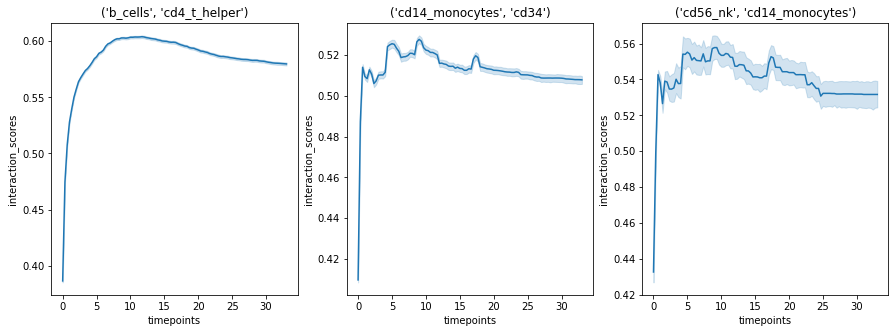

In [129]:
viz = ["('b_cells', 'cd4_t_helper')", "('cd14_monocytes', 'cd34')", "('cd56_nk', 'cd14_monocytes')"]
fig, ax = fig, ax_ = plt.subplots(ncols = 3, nrows = 1, figsize = (15,5))

counter = 0
for cp in tqdm(viz):
    d = all_information[all_information['cell_pairs'] == cp]
    sns.lineplot(x = 'timepoints', y = 'interaction_scores', data = d, ax = ax_[counter])
    ax_[counter].set_title(cp)
#     ax_[counter].set(xlim = (5,None))
    counter += 1